# Ermittle Wegstrecken für Sonntage

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

In [2]:
df = pd.read_csv(r"C:\Users\thoma\Desktop\ev-modelling-repo\Rohdaten\NHTS_trips_processed.csv")

In [3]:
df.head()

,ID,Type_day,TRPTRANS,Trip_no,Whyfrom,Whyto,Distance,Trip_duration,Departure_hhmm,Arrival_hhmm,Departure,Arrival,Departure_t
0,300000071,1,3,1,1,4,8.439,15,1000,1015,600,615,40
1,300000071,1,3,2,4,1,8.286,20,1510,1530,910,930,61
2,300000072,1,6,1,2,1,135.191,120,700,900,420,540,28
3,300000072,1,6,2,1,2,131.367,150,1800,2030,1080,1230,72
4,300000073,1,3,1,1,2,3.621,15,845,900,525,540,35


## Filtern nach Sonntagen und Wegstrecke > 0

In [4]:
filt = (df["Type_day"] == 7) & (df["Distance"] > 0.0)
data = df[filt]

In [5]:
data.head()

,ID,Type_day,TRPTRANS,Trip_no,Whyfrom,Whyto,Distance,Trip_duration,Departure_hhmm,Arrival_hhmm,Departure,Arrival,Departure_t
117,300002271,7,3,1,1,4,14.653,25,845,910,525,550,35
118,300002271,7,3,2,4,1,14.571,25,1045,1110,645,670,43
172,300003092,7,3,1,1,3,2.717,5,1400,1405,840,845,56
173,300003092,7,3,2,3,1,2.733,5,1445,1450,885,890,59
182,300003281,7,3,1,1,4,79.223,98,1100,1238,660,758,44


## Wegstrecken in 2-dimensionaler Liste Speichern 
wege_ij[i-1][j-1] entspricht der Liste aller Wegstrecken vom Zustand i zum Zustand j

In [6]:
# initialisieren 5x5 Liste 
wege_ij = [[0 for i in range(5)] for j in range(5)]

In [7]:
for i in range(1, 6):
    for j in range(1, 6):
        if j == i:
            continue
        # filtern des Dataframes nach Ausgangs- und Zielzustandskombinationen
        filt = (data["Whyfrom"] == i) & (data["Whyto"] == j)
        # speichern der Liste der Distanzen zwischen den Zuständen in entsprechendem Feld
        wege_ij[i-1][j-1] = list(data[filt]["Distance"])

### Test

In [8]:
filt = (data["Whyfrom"] == 1) & (data["Whyto"] == 2)
weg_zuhause_arbeit = list(data[filt]["Distance"])

filt = (data["Whyfrom"] == 5) & (data["Whyto"] == 3)
weg_sonstiges_einkaufen = list(data[filt]["Distance"])

In [9]:
(wege_ij[0][1] == weg_zuhause_arbeit) and (wege_ij[4][2] == weg_sonstiges_einkaufen)

True

## Visualisieren der Histogramme

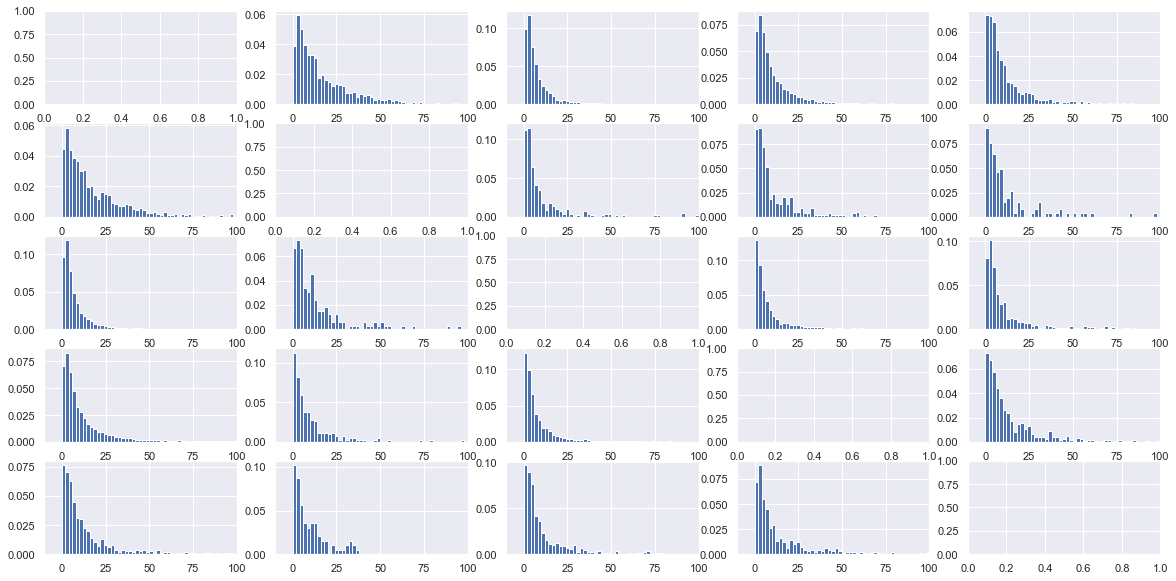

In [10]:
sns.set()
fig, axs = plt.subplots(5, 5, figsize=(20,10))
for i in range(5):
    for j in range(5):
        if i == j:
            continue
        axs[i][j].hist(wege_ij[i][j], bins=range(int(min(wege_ij[i][j])), int(max(wege_ij[i][j])) + 1, 2), density=True)
        axs[i][j].set_xlim(-10, 100)

In [11]:
# initialisieren 5x5 Liste für Parameter der Verteilungsfunktion 
shape_ij = [[0 for i in range(5)] for j in range(5)]
scale_ij = [[0 for i in range(5)] for j in range(5)]
loc_ij = [[0 for i in range(5)] for j in range(5)]
pdf_ij = [[0 for i in range(5)] for j in range(5)]
x = np.linspace(0, 500, 1000)

for i in range(5):
    for j in range(5):
        if j == i:
            continue
        shape_ij[i][j], loc_ij[i][j], scale_ij[i][j] = stats.lognorm.fit(wege_ij[i][j], loc=0, scale=5)
        pdf_ij[i][j] = stats.lognorm.pdf(x, s=shape_ij[i][j], loc=loc_ij[i][j], scale=scale_ij[i][j])

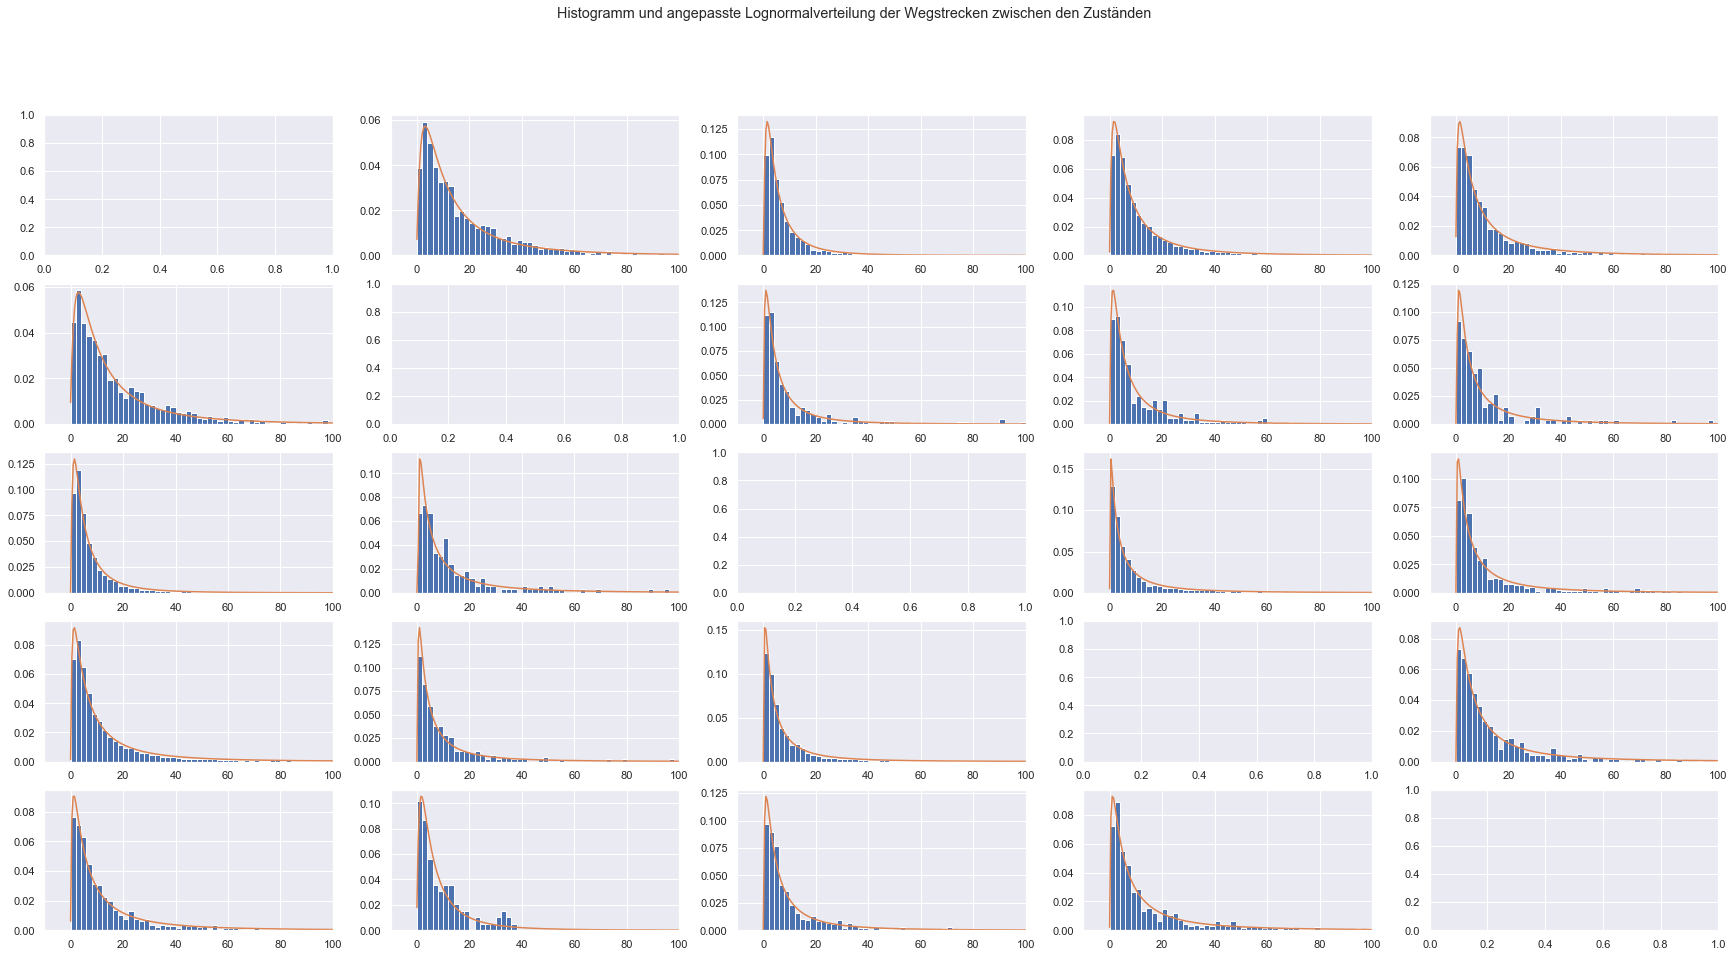

In [12]:
fig, axs = plt.subplots(5, 5, figsize=(30,15))
for i in range(5):
    for j in range(5):
        if i==j:
            continue
        axs[i][j].hist(wege_ij[i][j], bins=range(int(min(wege_ij[i][j])), int(max(wege_ij[i][j])) + 1, 2), density=True)
        axs[i][j].set_xlim(-10, 100)
        axs[i][j].plot(x, pdf_ij[i][j])
fig.suptitle("Histogramm und angepasste Lognormalverteilung der Wegstrecken zwischen den Zuständen");

## Testen samplen der Lognorm Funktion

In [13]:
# sample Werte generieren
sample_test = stats.lognorm.rvs(size=100000, s=shape_ij[0][1], loc=loc_ij[0][1], scale=scale_ij[0][1])

(-10, 100)

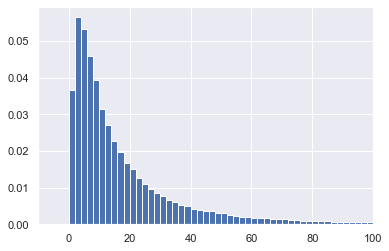

In [14]:
plt.figure()
plt.hist(sample_test, bins=range(int(min(wege_ij[0][1])), int(max(wege_ij[0][1])) + 1, 2), density=True)
plt.gca().set_xlim(-10,100)


## Speichern der Funktionsparameter

In [15]:
from pathlib import Path
import pickle
import os

root = os.getcwd()
if not os.path.exists(os.getcwd()+ "\\Simulationsdaten"):
    os.makedirs(root+"\\Simulationsdaten")

save_shape = root+"\\Simulationsdaten"+"\\Verteilung_Wegstrecken_Samstag_Shape.pickle"
save_scale = root+"\\Simulationsdaten"+"\\Verteilung_Wegstrecken_Samstag_Scale.pickle"
save_loc = root+"\\Simulationsdaten"+"\\Verteilung_Wegstrecken_Samstag_Loc.pickle"
save_wege = root+"\\Simulationsdaten"+"\\Liste_Wegstrecken_Samstag.pickle"

pickle.dump(shape_ij, open(save_shape, "wb"))
pickle.dump(scale_ij, open(save_scale, "wb"))
pickle.dump(loc_ij, open(save_loc, "wb"))
pickle.dump(wege_ij, open(save_wege, "wb"))